# LDA

## Compute Presence distribution across topics

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import spearmanr
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from sklearn.decomposition import LatentDirichletAllocation

# Check if multiple GPUs are available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Data
sentences_path = "/content/sentences.tsv"
labels_path = "/content/labels-cat.tsv"

sentences_df = pd.read_csv(sentences_path, sep="\t")
labels_df = pd.read_csv(labels_path, sep="\t")

# Merge sentences with labels based on Text-ID and Sentence-ID
data_df = sentences_df.merge(labels_df, on=["Text-ID", "Sentence-ID"], how="inner")

# Extract text data
texts = data_df["Text"].astype(str).values

# Convert text to a document-term matrix
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
text_matrix = vectorizer.fit_transform(texts)

# Apply LDA for topic modeling
num_topics = 75  # Adjust the number of topics as needed
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
topic_distributions = lda_model.fit_transform(text_matrix)

# Ensure topic distributions is a valid 2D array
topic_distributions = np.array(topic_distributions)

# Store topic probabilities in DataFrame
topic_features = pd.DataFrame(topic_distributions, columns=[f"Topic_Prob_{i}" for i in range(topic_distributions.shape[1])])

# Ensure label columns are numeric
label_columns = labels_df.columns[2:]  # Exclude Text-ID and Sentence-ID
data_df[label_columns] = data_df[label_columns].apply(pd.to_numeric, errors='coerce')

# Compute mean Presence per topic
data_df = data_df.reset_index()
data_df = pd.concat([data_df, topic_features], axis=1)
topic_presence = data_df.groupby(data_df[topic_features.columns].idxmax(axis=1))["Presence"].mean()

# Identify high- and low-Presence topics
high_presence_topics = topic_presence[topic_presence > 0.6].index.tolist()
low_presence_topics = topic_presence[topic_presence < 0.2].index.tolist()
print(f"High-Presence Topics: {high_presence_topics}")
print(f"Low-Presence Topics: {low_presence_topics}")

# Prepare dataset for classification
X = topic_features  # Features: Topic probability scores
y = data_df["Presence"].apply(lambda x: 1 if x > 0 else 0)  # Binary classification

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Evaluate Random Forest
y_pred_rf = rf_classifier.predict(X_test)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

# Train an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_classifier.fit(X_train, y_train)

# Evaluate XGBoost
y_pred_xgb = xgb_classifier.predict(X_test)
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")

# Save Presence per Topic Analysis
topic_presence.to_csv("lda_presence_analysis.csv", index=True)
print("Presence per LDA Analysis Saved.")

High-Presence Topics: ['Topic_Prob_1', 'Topic_Prob_12', 'Topic_Prob_23', 'Topic_Prob_26', 'Topic_Prob_33', 'Topic_Prob_36', 'Topic_Prob_39', 'Topic_Prob_6', 'Topic_Prob_64']
Low-Presence Topics: []

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.57      0.59      4298
           1       0.63      0.66      0.64      4654

    accuracy                           0.62      8952
   macro avg       0.62      0.62      0.62      8952
weighted avg       0.62      0.62      0.62      8952

Random Forest Accuracy: 0.6192


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:37:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.60      0.61      4298
           1       0.64      0.64      0.64      4654

    accuracy                           0.62      8952
   macro avg       0.62      0.62      0.62      8952
weighted avg       0.62      0.62      0.62      8952

XGBoost Accuracy: 0.6222
Presence per LDA Analysis Saved.


# BERTopic

## Correlations between labels

In [8]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.4 MB/s eta 0:00:00
  Using cached https://download.pytorch.org/whl/triton-3.2.0-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.met

In [5]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.6 MB/s eta 0:00:00


2025-02-12 19:01:05,304 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1399 [00:00<?, ?it/s]

2025-02-12 19:01:24,916 - BERTopic - Embedding - Completed ✓
2025-02-12 19:01:24,918 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-12 19:02:04,889 - BERTopic - Dimensionality - Completed ✓
2025-02-12 19:02:04,892 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-12 19:02:12,059 - BERTopic - Cluster - Completed ✓
2025-02-12 19:02:12,061 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-12 19:02:13,418 - BERTopic - Representation - Completed ✓
2025-02-12 19:02:13,421 - BERTopic - Topic reduction - Reducing number of topics
2025-02-12 19:02:14,339 - BERTopic - Topic reduction - Reduced number of topics from 597 to 50


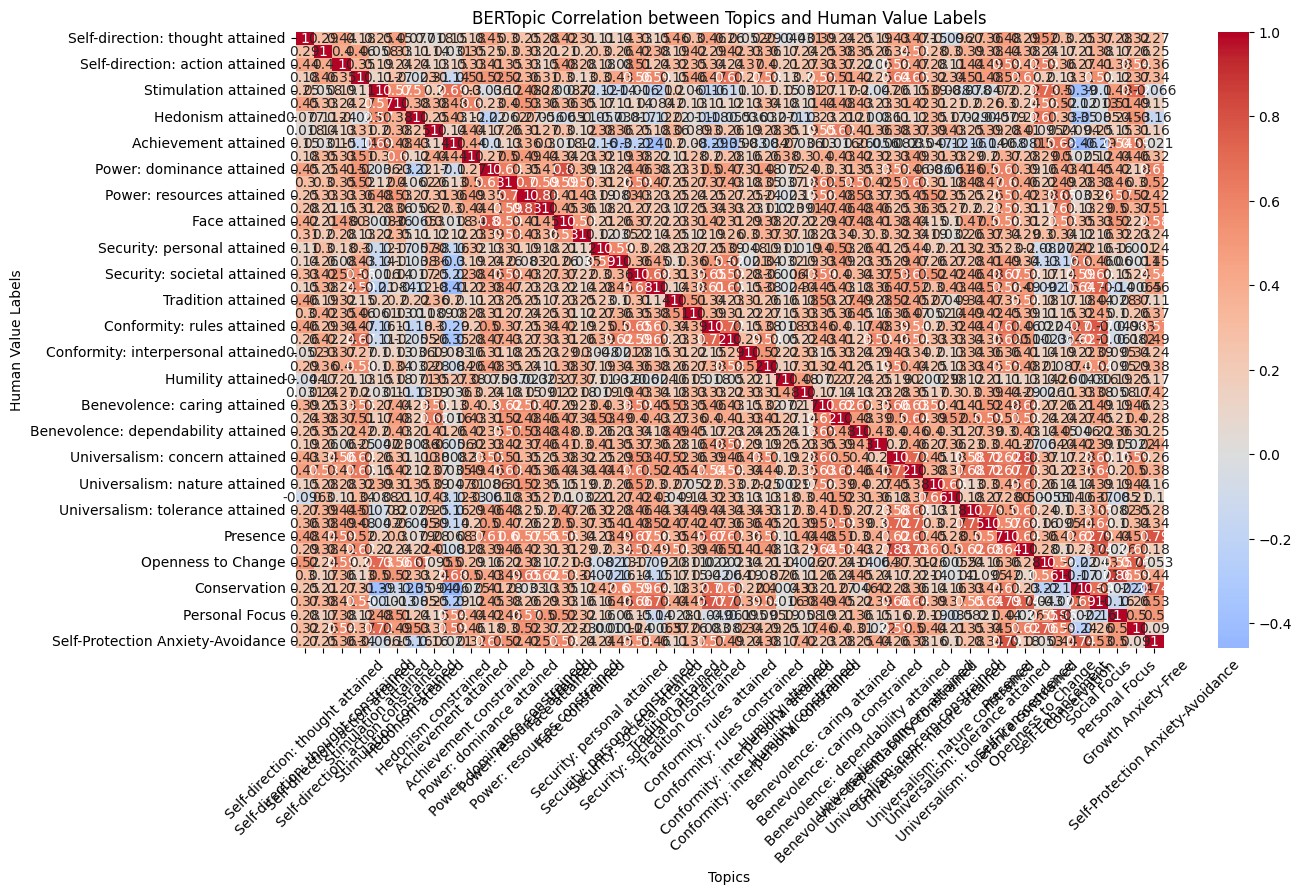


BERTopic-Label Correlation Analysis Completed. Results saved as 'bertopic_label_correlation.csv'.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import spearmanr
from sentence_transformers import SentenceTransformer

# Check if multiple GPUs are available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Data
sentences_path = "/content/sentences.tsv"
labels_path = "/content/labels-cat.tsv"

sentences_df = pd.read_csv(sentences_path, sep="\t")
labels_df = pd.read_csv(labels_path, sep="\t")

# Merge sentences with labels based on Text-ID and Sentence-ID
data_df = sentences_df.merge(labels_df, on=["Text-ID", "Sentence-ID"], how="inner")

# Extract text data
texts = data_df["Text"].astype(str).values

# Load a Transformer-based Sentence Embedding Model with GPU support
embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

# Apply BERTopic with GPU support
bertopic_model = BERTopic(nr_topics=50, embedding_model=embedding_model, verbose=True)
topics_bertopic, probs = bertopic_model.fit_transform(texts)

# Assign topics
data_df["Topic"] = np.array(topics_bertopic).astype(int)

# Ensure label columns are numeric
label_columns = labels_df.columns[2:]  # Exclude Text-ID and Sentence-ID
data_df[label_columns] = data_df[label_columns].apply(pd.to_numeric, errors='coerce')

# Compute mean values per topic
topic_means = data_df.groupby("Topic")[label_columns].mean()

# Compute Spearman correlation properly
correlation_df_bertopic = topic_means.corr(method="spearman")

# Visualize
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_df_bertopic, annot=True, cmap="coolwarm", center=0)
plt.title("BERTopic Correlation between Topics and Human Value Labels")
plt.xlabel("Topics")
plt.ylabel("Human Value Labels")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Save results
correlation_df_bertopic.to_csv("bertopic_label_correlation.csv", index=True)

print("\nBERTopic-Label Correlation Analysis Completed. Results saved as 'bertopic_label_correlation.csv'.")


## Compute Presence distribution across topics

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import spearmanr
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

# Check if multiple GPUs are available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Data
sentences_path = "/content/sentences.tsv"
labels_path = "/content/labels-cat.tsv"

sentences_df = pd.read_csv(sentences_path, sep="\t")
labels_df = pd.read_csv(labels_path, sep="\t")

# Merge sentences with labels based on Text-ID and Sentence-ID
data_df = sentences_df.merge(labels_df, on=["Text-ID", "Sentence-ID"], how="inner")

# Extract text data
texts = data_df["Text"].astype(str).values

# Load a Transformer-based Sentence Embedding Model with GPU support
embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

# Apply BERTopic with GPU support
bertopic_model = BERTopic(nr_topics=40, embedding_model=embedding_model, verbose=True)
topics_bertopic, probs = bertopic_model.fit_transform(texts)

# Ensure probs is a valid 2D array
if probs is None:
    probs = np.zeros((len(texts), 50))  # Default to zero probabilities
else:
    probs = np.array(probs)
    if probs.ndim == 1:
        probs = probs.reshape(-1, 1)  # Ensure it's a 2D array

# Store topic probabilities in DataFrame
data_df["Topic_Prob"] = list(probs)

# Ensure label columns are numeric
label_columns = labels_df.columns[2:]  # Exclude Text-ID and Sentence-ID
data_df[label_columns] = data_df[label_columns].apply(pd.to_numeric, errors='coerce')

# Restore topic assignments
data_df["Topic"] = topics_bertopic

# Compute mean Presence per topic
topic_presence = data_df.groupby("Topic")["Presence"].mean()

# Identify high- and low-Presence topics
high_presence_topics = topic_presence[topic_presence > 0.6].index.tolist()
low_presence_topics = topic_presence[topic_presence < 0.2].index.tolist()
print(f"High-Presence Topics: {high_presence_topics}")
print(f"Low-Presence Topics: {low_presence_topics}")

# Use topic probabilities instead of one-hot encoding
topic_features = pd.DataFrame(probs, columns=[f"Topic_Prob_{i}" for i in range(probs.shape[1])])

# Prepare dataset for classification
X = topic_features  # Features: Topic probability scores
y = data_df["Presence"].apply(lambda x: 1 if x > 0 else 0)  # Binary classification

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Evaluate Random Forest
y_pred_rf = rf_classifier.predict(X_test)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

# Train an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_classifier.fit(X_train, y_train)

# Evaluate XGBoost
y_pred_xgb = xgb_classifier.predict(X_test)
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")

# Save Presence per Topic Analysis
topic_presence.to_csv("bertopic_presence_analysis.csv", index=True)
print("Presence per BERTopic Analysis Saved.")

2025-02-12 19:57:01,671 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1399 [00:00<?, ?it/s]

2025-02-12 19:57:24,368 - BERTopic - Embedding - Completed ✓
2025-02-12 19:57:24,371 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-12 19:58:03,751 - BERTopic - Dimensionality - Completed ✓
2025-02-12 19:58:03,755 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-12 19:58:11,507 - BERTopic - Cluster - Completed ✓
2025-02-12 19:58:11,509 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-12 19:58:12,857 - BERTopic - Representation - Completed ✓
2025-02-12 19:58:12,861 - BERTopic - Topic reduction - Reducing number of topics
2025-02-12 19:58:13,764 - BERTopic - Topic reduction - Reduced number of topics from 585 to 40


High-Presence Topics: [0, 4, 8, 25]
Low-Presence Topics: [28, 36]

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.36      0.42      4298
           1       0.53      0.68      0.60      4654

    accuracy                           0.52      8952
   macro avg       0.52      0.52      0.51      8952
weighted avg       0.52      0.52      0.51      8952

Random Forest Accuracy: 0.5248

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.34      0.40      4298
           1       0.53      0.68      0.59      4654

    accuracy                           0.52      8952
   macro avg       0.51      0.51      0.50      8952
weighted avg       0.51      0.52      0.50      8952

XGBoost Accuracy: 0.5156
Presence per BERTopic Analysis Saved.


# NMF

## Compute Presence distribution across topics

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import spearmanr
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from sklearn.decomposition import NMF

# Check if multiple GPUs are available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Data
sentences_path = "/content/sentences.tsv"
labels_path = "/content/labels-cat.tsv"

sentences_df = pd.read_csv(sentences_path, sep="\t")
labels_df = pd.read_csv(labels_path, sep="\t")

# Merge sentences with labels based on Text-ID and Sentence-ID
data_df = sentences_df.merge(labels_df, on=["Text-ID", "Sentence-ID"], how="inner")

# Extract text data
texts = data_df["Text"].astype(str).values

# Convert text to a document-term matrix
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
text_matrix = vectorizer.fit_transform(texts)

# Apply NMF for topic modeling
num_topics = 100  # Adjust the number of topics as needed
nmf_model = NMF(n_components=num_topics, random_state=42)
topic_distributions = nmf_model.fit_transform(text_matrix)

# Ensure topic distributions is a valid 2D array
topic_distributions = np.array(topic_distributions)

# Store topic probabilities in DataFrame
topic_features = pd.DataFrame(topic_distributions, columns=[f"Topic_Prob_{i}" for i in range(topic_distributions.shape[1])])

# Ensure label columns are numeric
label_columns = labels_df.columns[2:]  # Exclude Text-ID and Sentence-ID
data_df[label_columns] = data_df[label_columns].apply(pd.to_numeric, errors='coerce')

# Compute mean Presence per topic
data_df = data_df.reset_index()
data_df = pd.concat([data_df, topic_features], axis=1)
topic_presence = data_df.groupby(data_df[topic_features.columns].idxmax(axis=1))["Presence"].mean()

# Identify high- and low-Presence topics
high_presence_topics = topic_presence[topic_presence > 0.6].index.tolist()
low_presence_topics = topic_presence[topic_presence < 0.2].index.tolist()
print(f"High-Presence Topics: {high_presence_topics}")
print(f"Low-Presence Topics: {low_presence_topics}")

# Prepare dataset for classification
X = topic_features  # Features: Topic probability scores
y = data_df["Presence"].apply(lambda x: 1 if x > 0 else 0)  # Binary classification

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Evaluate Random Forest
y_pred_rf = rf_classifier.predict(X_test)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

# Train an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_classifier.fit(X_train, y_train)

# Evaluate XGBoost
y_pred_xgb = xgb_classifier.predict(X_test)
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")

# Save Presence per Topic Analysis
topic_presence.to_csv("nmf_presence_analysis.csv", index=True)
print("Presence per NMF Analysis Saved.")

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


High-Presence Topics: ['Topic_Prob_1', 'Topic_Prob_14', 'Topic_Prob_15', 'Topic_Prob_17', 'Topic_Prob_25', 'Topic_Prob_29', 'Topic_Prob_3', 'Topic_Prob_31', 'Topic_Prob_35', 'Topic_Prob_36', 'Topic_Prob_38', 'Topic_Prob_39', 'Topic_Prob_43', 'Topic_Prob_47', 'Topic_Prob_60', 'Topic_Prob_77', 'Topic_Prob_79', 'Topic_Prob_9', 'Topic_Prob_94']
Low-Presence Topics: ['Topic_Prob_0', 'Topic_Prob_51']

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.59      0.61      4298
           1       0.64      0.68      0.66      4654

    accuracy                           0.64      8952
   macro avg       0.64      0.64      0.64      8952
weighted avg       0.64      0.64      0.64      8952

Random Forest Accuracy: 0.6375


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:10:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.66      0.64      4298
           1       0.66      0.62      0.64      4654

    accuracy                           0.64      8952
   macro avg       0.64      0.64      0.64      8952
weighted avg       0.64      0.64      0.64      8952

XGBoost Accuracy: 0.6382
Presence per NMF Analysis Saved.
